<a href="https://colab.research.google.com/github/GSukr/Ensemble_CNN_Classification_with_Data_Augmentation/blob/master/FMimageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of Fashion MNIST images


*  Data source: https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/
*  Contains a training set of 60,000 examples and a test set of 10,000 examples. 
*  Each example is a 28x28 grayscale image, associated with a label from 10 classes:

<table>
<thead>
<tr>
<th>Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td>1</td>
<td>Trouser</td>
</tr>
<tr>
<td>2</td>
<td>Pullover</td>
</tr>
<tr>
<td>3</td>
<td>Dress</td>
</tr>
<tr>
<td>4</td>
<td>Coat</td>
</tr>
<tr>
<td>5</td>
<td>Sandal</td>
</tr>
<tr>
<td>6</td>
<td>Shirt</td>
</tr>
<tr>
<td>7</td>
<td>Sneaker</td>
</tr>
<tr>
<td>8</td>
<td>Bag</td>
</tr>
<tr>
<td>9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>




A convolution neural network (CNN) with judiciously selected architecture and parameters may achieve a classification accuracy of around 92% with test examples. This notebook investigates some simple mechanisms to improve classification accuracy. Specifically, it explores whether:
	
1.    **Data augmentation** by distorting training images (using *ImageDataGenerator*) helps with generalization, and
2.    An **ensemble** of similar CNN models does better than its constituent models. 

Aggregate class probabilties of the constituent models for prediction. Trained models are saved and may be used to investigate alternate ensemble mechanisms.


In [0]:
# Import libraries
import pandas as pd # for data handling
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # to display plots
import time # to time runs
from sklearn.metrics import accuracy_score, confusion_matrix  # for accuracy
from sklearn.model_selection import train_test_split # for validation data

from tensorflow.keras.datasets.fashion_mnist import load_data # to get data

# for convolution neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint # for saving models

# for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# to display network
from tensorflow.keras.utils import plot_model
from IPython.display import Image

### Get data

In [0]:
def getFashionMNISTdata(valid_prop=1/6):
  """Returns training, validation, and test data. Usage:
  input_shape, nClasses, X, Xv, Xt, y, yv, yt = getFashionMNISTdata()"""
  
  (x_train,y_train), (Xt,yt) = load_data()
  
  # reshape and reshape data for network
  x_train, Xt = [o.reshape((-1,28,28,1)).astype('float32')/255
                 for o in [x_train, Xt]]
  
  input_shape = x_train.shape[1:] # input shape for model
  nClasses = len(np.unique(y_train)) # number of output classes
  
  # reserve some training data for validation
  X, Xv, y, yv = train_test_split(x_train, y_train,
                                  test_size=valid_prop,
                                  random_state=2019)
  
  print("\nImage: height = %d, width = %d, channels = %d\n" %input_shape)
  print("Number of output classes = %d\n" %nClasses)
  print("Number of examples:")
  print("\tTraining: %d" % len(X))
  print("\tValidation: %d" % len(Xv))
  print("\tTest: %d" % len(Xt))
  
  return input_shape, nClasses, X, Xv, Xt, y, yv, yt

In [0]:
input_shape, nClasses, X, Xv, Xt, y, yv, yt = getFashionMNISTdata()


Image: height = 28, width = 28, channels = 1

Number of output classes = 10

Number of examples:
	Training: 50000
	Validation: 10000
	Test: 10000


### Create convolution neural network model

In [0]:
def getConvNN(input_shape, nClasses):
    """Returns CNN model with specified architecture and parameters. Usage:
    model = getConvNN(input_shape, nClasses)"""
          
    # Parameters for CNN models (change as desired)
    ch1, ch2 = 32, 64 # number of output channels
    kernel = (3,3) # filter shape
    pool = (2,2) # max pool size
    nDense = 512 # dense layer size
    drop, dropDense = 0.25, 0.5
    
    model = Sequential() # create model                

    # CONV => BN => CONV => BN => POOL => DROPOUT
    model.add(Conv2D(ch1, kernel, padding="same", activation="relu", 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(ch1, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(Dropout(drop))

    # CONV => BN => CONV => BN => POOL => DROPOUT
    model.add(Conv2D(ch2, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(ch2, kernel, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool))
    model.add(Dropout(drop))

    model.add(Flatten()) 

    # Dense => BN => DROPOUT
    model.add(Dense(nDense, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropDense))

    # output softmax layer
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)    

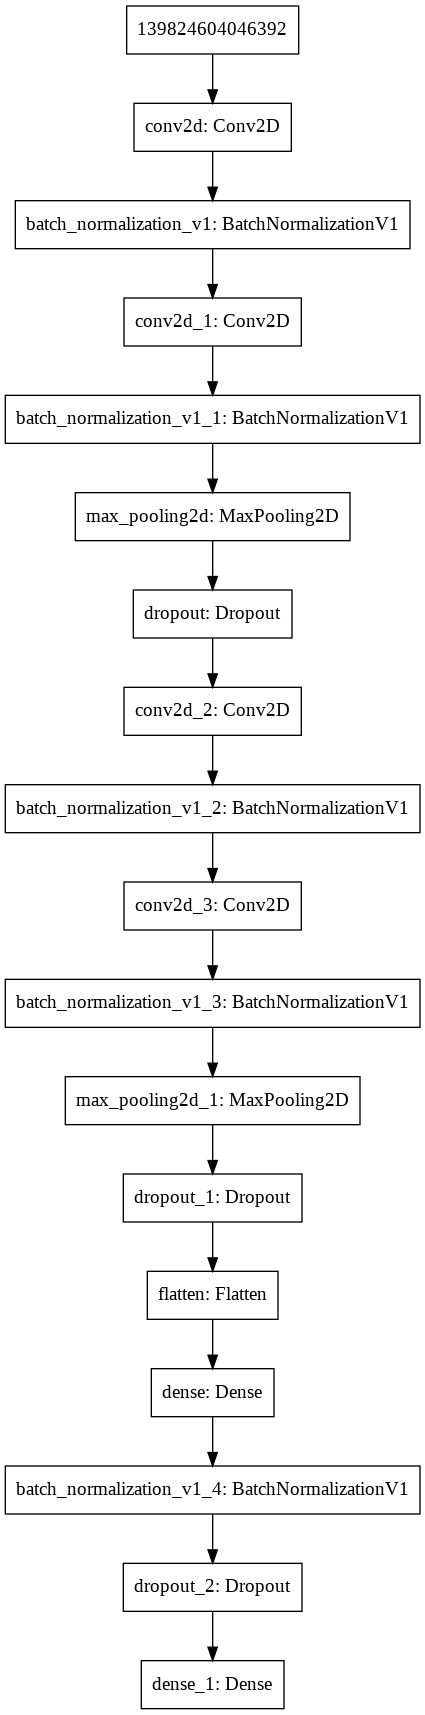

In [0]:
model = getConvNN(input_shape, nClasses) # create model instance
model.summary() # display summary
plot_model(model, to_file='model.png') # display network 
Image('model.png')

### Generate augmented data

In [0]:
def augmentedData(X, y, Xv, yv, batch_size):
  """Returns batches of augmented data for training and validation. Usage:
  train_batches, valid_batches = augmentedData(X, y, Xv, yv)"""
  generator = ImageDataGenerator(rotation_range=5,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 shear_range=0.2,
                                 zoom_range=0.05) # change as needed
  y, yv = to_categorical(y, nClasses), to_categorical(yv, nClasses)
  train_batches = generator.flow(X, y, batch_size=batch_size)
  valid_batches = generator.flow(Xv, yv, batch_size=batch_size)
  return train_batches, valid_batches

### Utilities

In [0]:
def plotHistory(modelName, history, start=0):
    """Plots training and validation accuracy"""
    plt.plot(history.history['acc'][start:])
    plt.plot(history.history['val_acc'][start:])
    plt.title(modelName+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Train model using augmented data

In [0]:
def trainModel(modelName, model, train_batches, valid_batches, epochs):
  """Trains model and saves weights for best model found. Usage:
  model = trainModel(modelName,train_batches,valid_batches,epochs)"""
  
  print("\nTraining model: %s\n" %modelName)
  bestWts = modelName + ".aug.weights.hdf5" # best weights file
  print('Best weights saved in %s\n: ' %bestWts)
  # model = getConvNN(input_shape, nClasses)
  
  checkpoint = ModelCheckpoint(filepath=bestWts, 
                               monitor='val_acc',
                               verbose=1, 
                               save_best_only=True, 
                               mode='max')
  callbacks = [checkpoint]
  history = model.fit_generator(train_batches,
                                epochs=epochs,
                                steps_per_epoch=len(train_batches),
                                validation_data=valid_batches, 
                                validation_steps=len(valid_batches), 
                                use_multiprocessing=True,
                                callbacks=callbacks)
  
  plotHistory(modelName, history) # plot accuracy
  return model # accuracy

In [0]:
results = [] # for results
probs = np.zeros((len(yt), nClasses)) # for cumulative probabilities

2 Models to be trained:
	 model_9
	 model_10

Training model: model_9

Best weights saved in model_9.aug.weights.hdf5
: 
Epoch 1/20
40/40 [==============================] - 3s 63ms/step - loss: 0.2014 - acc: 0.9468

Epoch 00001: val_acc improved from -inf to 0.94680, saving model to model_9.aug.weights.hdf5
196/196 [==============================] - 15s 77ms/step - loss: 0.0749 - acc: 0.9724 - val_loss: 0.2014 - val_acc: 0.9468
Epoch 2/20
40/40 [==============================] - 3s 63ms/step - loss: 0.1892 - acc: 0.9460

Epoch 00002: val_acc did not improve from 0.94680
196/196 [==============================] - 15s 78ms/step - loss: 0.0761 - acc: 0.9733 - val_loss: 0.1892 - val_acc: 0.9460
Epoch 3/20
40/40 [==============================] - 3s 64ms/step - loss: 0.1881 - acc: 0.9454

Epoch 00003: val_acc did not improve from 0.94680
196/196 [==============================] - 14s 74ms/step - loss: 0.0753 - acc: 0.9732 - val_loss: 0.1881 - val_acc: 0.9454
Epoch 4/20
40/40 [==============

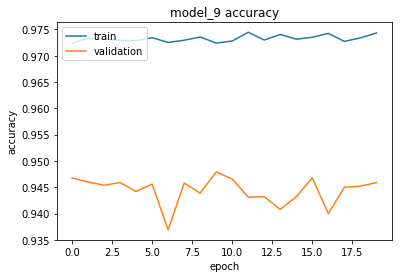

Model: model_9, accuracy=94.66%, cummulative accuracy=94.90%, time=293.2620

Training model: model_10

Best weights saved in model_10.aug.weights.hdf5
: 
Epoch 1/20
40/40 [==============================] - 2s 62ms/step - loss: 0.2098 - acc: 0.9467

Epoch 00001: val_acc improved from -inf to 0.94670, saving model to model_10.aug.weights.hdf5
196/196 [==============================] - 15s 76ms/step - loss: 0.0688 - acc: 0.9745 - val_loss: 0.2098 - val_acc: 0.9467
Epoch 2/20
40/40 [==============================] - 2s 62ms/step - loss: 0.1828 - acc: 0.9429

Epoch 00002: val_acc did not improve from 0.94670
196/196 [==============================] - 14s 73ms/step - loss: 0.0725 - acc: 0.9749 - val_loss: 0.1828 - val_acc: 0.9429
Epoch 3/20
40/40 [==============================] - 2s 62ms/step - loss: 0.2150 - acc: 0.9475

Epoch 00003: val_acc improved from 0.94670 to 0.94750, saving model to model_10.aug.weights.hdf5
196/196 [==============================] - 14s 73ms/step - loss: 0.0754 - 

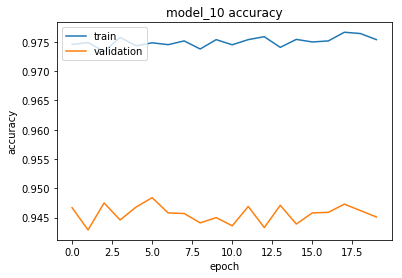

Model: model_10, accuracy=94.55%, cummulative accuracy=94.94%, time=289.4499


In [0]:
start, nModels = 9, 2 # start index and number of models to train
models = ["model_"+str(i) for i in range(start, start+nModels)] # model names
print("%s Models to be trained:" %nModels)
for m in models:
  print("\t %s" %m)

batch_size = 256
epochs = 20 # number of training epochs 

for m in models:
  train_batches, valid_batches = augmentedData(X, y, Xv, yv, batch_size)
  st = time.time() # start time for training model
  model = trainModel(m, model, train_batches, valid_batches, epochs)
  t = time.time() - st # time to train model
  prob = model.predict(Xt) # predict probabilities for test examples
  acc = accuracy_score(yt, prob.argmax(axis=1)) # accuracy
  probs += prob # cumulative probability
  accCum = accuracy_score(yt, probs.argmax(axis=1)) # cumulative accuracy
  results .append([m, acc, accCum, t])
  print('Model: %s, accuracy=%4.2f%%, cummulative accuracy=%4.2f%%, time=%4.4f'
       %(m, acc*100, accCum*100, t))

### Examine results on test data

In [0]:
cols = ['model', 'accuracy', 'cumulative accuracy', 'training time']
df = pd.DataFrame(results, columns= cols)
pd.options.display.float_format = '{:,.4f}'.format
df

,model,accuracy,cumulative accuracy,training time
0,model_1,0.9327,0.9327,294.4502
1,model_2,0.9412,0.9407,288.0150
2,model_3,0.9429,0.9424,287.8359
3,model_4,0.9388,0.9444,286.5892
4,model_5,0.9414,0.9458,289.2242
5,model_6,0.9467,0.9486,291.4422
6,model_7,0.9419,0.9479,287.4203
7,model_8,0.9439,0.9481,282.4583
8,model_9,0.9466,0.9490,293.2620
9,model_10,0.9455,0.9494,289.4499


In [0]:
# display confusion matrix
predicted = probs.argmax(axis=1)
pd.DataFrame(confusion_matrix(yt, predicted))

,0,1,2,3,4,5,6,7,8,9
0,899,0,11,7,1,1,77,0,4,0
1,0,991,0,7,0,0,1,0,1,0
2,12,1,909,7,32,0,39,0,0,0
3,7,1,6,952,11,0,22,0,1,0
4,0,0,10,19,942,0,29,0,0,0
5,0,0,0,0,0,997,0,2,0,1
6,65,1,23,14,39,0,855,0,3,0
7,0,0,0,0,0,7,0,987,0,6
8,1,0,0,2,0,0,1,0,996,0
9,0,0,0,0,0,5,0,29,0,966


#### Display misclassified images

In [0]:
def displayDigits(images, labels, nCols):
  """Displays images with labels (nCols per row)
  - images: list of vectors with 784 (28x28) grayscale values
  - labels: list of digits represented by images"""
  nRows = np.ceil(len(labels)/nCols).astype('int') # number of rows
  plt.figure(figsize=(2*nCols,2*nRows)) # figure size
  for i in range(len(labels)):
    plt.subplot(nRows,nCols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(28, 28), interpolation='nearest')
    plt.xlabel(str(labels[i]), fontsize=14)
  plt.show()
  return

Labels displayed as True > Predicted


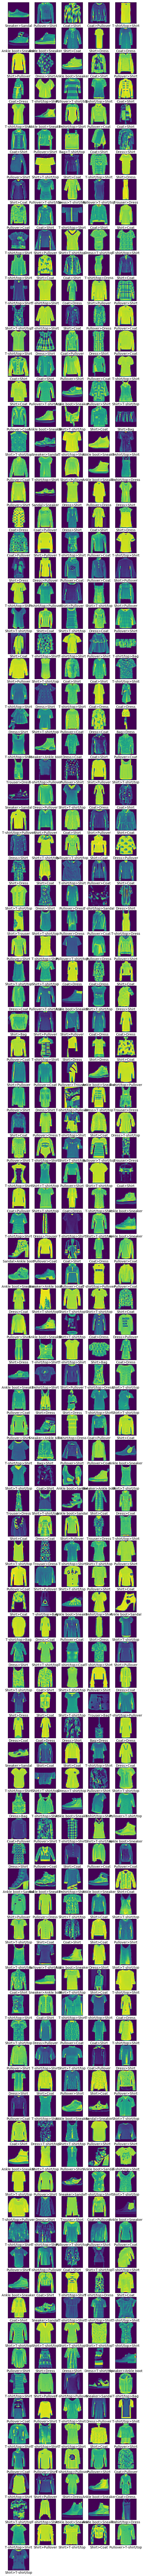

In [0]:
wrong = [i for i,(t,p) in enumerate(zip(yt, predicted)) if t!=p] # incorrect
items = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
true = [items[i] for i in yt[wrong]]
pred = [items[i] for i in predicted[wrong]]

labels = [t+'>'+p for t,p in zip(true, pred)]
images = Xt[wrong]
print("Labels displayed as True > Predicted")
displayDigits(images, labels, nCols=5)